In [16]:
import pandas as pd
import sys
import os
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing

# ignore future and convergence warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Ignore warnings related to statsmodeling
warnings.filterwarnings("ignore", module="statsmodels")

sys.path.append(os.path.abspath('../utils'))
from tinne_utils import analyze_state_data, get_quarter_start_date, plot_num_colonies_over_time

In [17]:
# set working directory
ITM_DIR = os.path.join(os.getcwd(), '../data/cleaned')

In [18]:
# read in data
bees = pd.read_csv(os.path.join(ITM_DIR, 'bees_full_cleaned.csv'))

In [19]:
bees.isna().sum()

state                             0
latitude                          0
longitude                         0
quarter                           0
temperature_2m_meanmean           0
temperature_2m_meansum            0
relative_humidity_2m_meanmean     0
relative_humidity_2m_meansum      0
wind_speed_10m_maxmax             0
temperature_2m_maxmax             0
relative_humidity_2m_maxmax       0
temperature_2m_minmin             0
relative_humidity_2m_minmin       0
precipitation_hours_sum           0
moderate_drizzle_sum              0
moderate_rain_sum                 0
light_rain_sum                    0
heavy_rain_sum                    0
overcast_sum                      0
partly_cloudy_sum                 0
clear_sky_sum                     0
light_drizzle_sum                 0
mainly_clear_sum                  0
heavy_drizzle_sum                 0
light_snow_sum                    0
heavy_snow_sum                    0
moderate_snow_sum                 0
year                        

In [20]:
# show rows where there are missing values
missing_rows = bees[bees.isna().any(axis=1)]
print(missing_rows)

               state   latitude   longitude  quarter  temperature_2m_meanmean  \
17           Alabama  32.806671  -86.791130        2                22.542523   
49           Arizona  33.729759 -111.431221        2                19.373717   
81          Arkansas  34.969704  -92.373123        2                21.241589   
113       California  36.116203 -119.681564        2                22.851115   
145         Colorado  39.059811 -105.311104        2                 6.644207   
177      Connecticut  41.597782  -72.755371        2                14.286915   
209          Florida  27.766279  -81.686783        2                25.568500   
241          Georgia  33.040619  -83.643074        2                22.581294   
273           Hawaii  20.902977 -156.207483        2                24.877555   
301            Idaho  44.068202 -114.742043        2                 2.643092   
333         Illinois  40.633125  -89.398529        2                15.901179   
365          Indiana  39.849

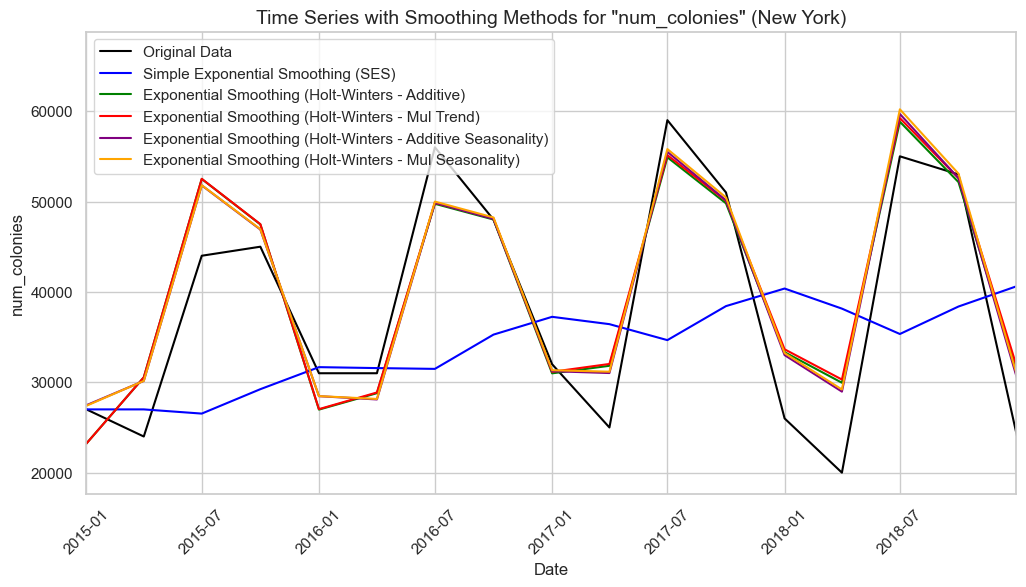

In [21]:
state = 'New York'
analyze_state_data(bees, state)

In [22]:
# Target date to impute
target_date = pd.Timestamp('2019-04-01')

# Columns to impute
cols_to_impute = [
    'num_colonies', 'varroa_mites', 'other_pests_and_parasites',
    'diseases', 'pesticides', 'other_or_unknown'
]

# Apply the function to create a new datetime column
imputed_bees = bees.copy()
imputed_bees['date'] = imputed_bees.apply(get_quarter_start_date, axis=1)

# Set the datetime column as the index
imputed_bees.set_index('date', inplace=True)

# Ensure data is sorted by date
imputed_bees = imputed_bees.sort_index()

# Loop through each state
for state in imputed_bees['state'].unique():
    # Boolean mask for this state and target date
    mask = (imputed_bees['state'] == state) & (imputed_bees.index == target_date)

    for col in cols_to_impute:
        try:
            # Only try to impute if value is missing
            if imputed_bees.loc[mask, col].isna().any():
                # Build time series for that state and column
                ts = imputed_bees[imputed_bees['state'] == state][col].dropna()
                ts = ts.sort_index()

                # Reindex the time series to match quarterly frequency starting from January
                # Create a date range with a quarterly frequency and reindex the series
                ts = ts.reindex(pd.date_range(start=ts.index.min(), end=ts.index.max(), freq='QS-JAN'))

                # Skip if not enough data
                if len(ts.dropna()) >= 8:  # Drop NaN values before modeling
                    # Fit the Exponential Smoothing model
                    model = ExponentialSmoothing(ts, trend='add', seasonal='add', seasonal_periods=4)
                    fit = model.fit(optimized=True)

                    # Forecast the missing value at the target date
                    prediction = fit.predict(start=target_date, end=target_date)

                    # Set the imputed value
                    imputed_bees.loc[mask, col] = prediction.iloc[0]

        except Exception as e:
            print(f"Could not impute for state '{state}', column '{col}': {e}")

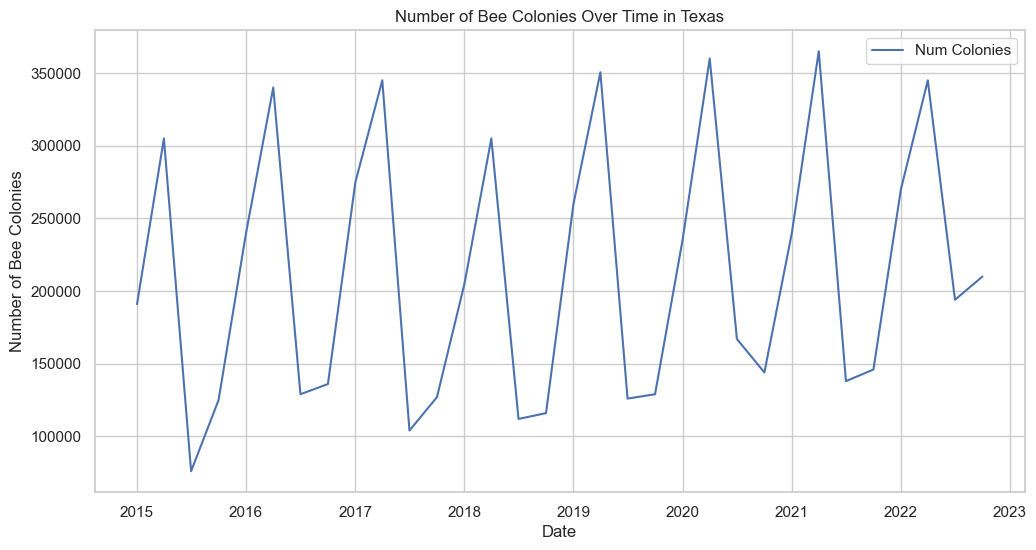

In [23]:
state = 'Texas'
plot_num_colonies_over_time(imputed_bees, state)

In [24]:
# save csv file
OUT_DIR = os.path.join(os.getcwd(), '../data/cleaned')

imputed_bees.to_csv(os.path.join(OUT_DIR, 'bees_clean_imputed.csv'), index=False)